# (b.i)

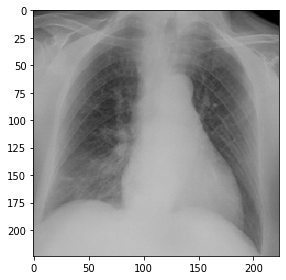

In [15]:
from skimage.io import imread, imshow
image = imread('train2\\img_0.jpg', as_gray=True)
imshow(image)

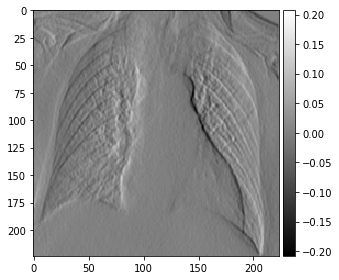

In [16]:
# Feature Extraction: Extracting vertical Edges
# calculating vertical edges using prewitt kernel
from skimage.filters import prewitt_h,prewitt_v

edges_prewitt_vertical = prewitt_v(image)
imshow(edges_prewitt_vertical, cmap='gray')

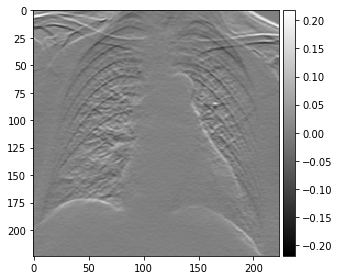

In [17]:
# Feature Extraction: Extracting horizontal Edges
# calculating vertical edges using prewitt kernel

edges_prewitt_horizontal = prewitt_h(image)
imshow(edges_prewitt_horizontal, cmap='gray')

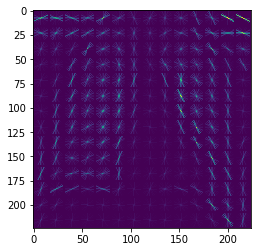

In [18]:
# Feature Extraction: Extracting HoG feature
from skimage.feature import hog
import matplotlib.pyplot as plt

ppc = 16
hog_images = []
hog_features = []

fd, hog_image = hog(image, orientations=16, pixels_per_cell=(ppc, ppc), cells_per_block=(4, 4), visualize=True)
hog_images.append(hog_image)
hog_features.append(fd)

plt.imshow(hog_images[0])

# b(ii)

# read label

In [19]:
class DataPoint(object):

    def __init__(self, feats):
        self.label = feats['label']


In [20]:
def parse_dataset(filename):
    
    data_file = open(filename, 'r')  
    dataset = []  

    for index, line in enumerate(data_file):
        if index == 0:  
            continue
        
        strc = line.strip().split(',')
        dataset.append(DataPoint({'label': int(strc[-1])}))  
  
    return dataset

In [21]:
dataset = parse_dataset('train.csv')

In [22]:
label = []
for i in range(len(dataset)):
    label.append(dataset[i].label)

In [23]:
import numpy as np
label = np.array(label)
label_2 = np.copy(label)


# read image

In [24]:
mat = []

for i in range(len(dataset)):
    imgname = "train2\\img_" + str(i) + ".jpg"
    image = imread(imgname, as_gray=True)   
    features = np.reshape(image, (224*224))
    mat.append(features)

mat = np.array(mat)
print(features.shape)
print(mat.shape)

(50176,)
(250, 50176)


In [25]:
mat_hog = []

for i in range(len(dataset)):
    imgname = "train2\\img_" + str(i) + ".jpg"
    image = imread(imgname, as_gray=True) 
    mat_hog.append(image)
    

In [26]:
ppc = 16
hog_images = []
hog_features = []
for image in mat_hog:
    fd, hog_image = hog(image, orientations=16, pixels_per_cell=(ppc, ppc), cells_per_block=(4, 4), visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

In [27]:
hog_images = np.array(hog_images)
hog_features = np.array(hog_features)

In [28]:
print(hog_features.shape)

(250, 30976)


# Train SVM classifier with HOG features

In [145]:
from sklearn import svm
clf = svm.SVC(random_state=10)
label_2.resize(len(dataset),1)
data_frame = np.hstack((hog_features,label_2))
np.random.shuffle(data_frame)

In [146]:
percentage = 80
partition = int(len(hog_features)*percentage/100)

x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

clf.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=10, shrinking=True, tol=0.001,
    verbose=False)

In [147]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_pred = clf.predict(x_test)
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.6


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.60      1.00      0.75        30

    accuracy                           0.60        50
   macro avg       0.30      0.50      0.37        50
weighted avg       0.36      0.60      0.45        50



C:\Users\zhuch\Anaconda3\envs\cs670\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Train RandomForest classifier with HOG features

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hog_features, label, test_size=0.2, random_state=20)

def run_randomForest(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))

run_randomForest(X_train, X_test, y_train, y_test)

Accuracy:  0.54


# Train RandomForest classifier with Grayscale Pixel Values

In [149]:
X_train, X_test, y_train, y_test = train_test_split(mat, label, test_size=0.2, random_state=20)
run_randomForest(X_train, X_test, y_train, y_test)

Accuracy:  0.42


# Fisher's score based on HoG feature

In [150]:
from skfeature.function.similarity_based import fisher_score
# X_train, X_test, y_train, y_test = train_test_split(hog_features, label, test_size=0.2, random_state=40)
score = fisher_score.fisher_score(x_train, y_train)
print(score)

[24821 27573 25061 ... 16778 30795  4394]


# Rank HoG features in an descending order according to fisher scores
# Train SVM classifier with the first 3000 HoG features

In [151]:
# Rank features in an descending order according to fisher scores and outputs the ranking index:
# idx = fisher_score.feature_ranking(score)
# print(idx)
from skfeature.function.similarity_based import fisher_score
score =  np.array(score)
idx = np.argsort(-score)

In [152]:
# Specify the number of selected features (e.g., 2000 for the evaluation purpose:
num_fea = 3000
selected_features_train = x_train[:, idx[0:num_fea]]
selected_features_test = x_test[:, idx[0:num_fea]]

clf = svm.LinearSVC()
clf.fit(selected_features_train, y_train)
y_predict = clf.predict(selected_features_test)
acc = accuracy_score(y_test, y_predict)
print(acc)


0.42


In [153]:
print(selected_features_train.shape)

(200, 3000)


# Train SVM classifier with the 3000 randomly selected HoG features

In [154]:
idx_random = np.copy(idx)
np.random.shuffle(idx_random)

In [155]:
num_fea = 3000
selected_features_train = x_train[:, idx_random[0:num_fea]]
selected_features_test = x_test[:, idx_random[0:num_fea]]

clf = svm.LinearSVC()
clf.fit(selected_features_train, y_train)
y_predict = clf.predict(selected_features_test)
acc = accuracy_score(y_test, y_predict)
print(acc)

0.44


In [156]:
print(selected_features_train.shape)

(200, 3000)


# Train LogisticRegression classifier with the first 3000 HoG features

In [45]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(selected_features_train, y_train)
y_predict = clf.predict(selected_features_test)
acc = accuracy_score(y_test, y_predict)
print(acc)

0.54


In [44]:
print(selected_features_train.shape)

(200, 3000)


# Train SVM classifier with HOG features on the train set
# Apply the model on the test set

In [69]:
dataset_train = parse_dataset('train.csv')
label_train = []
for i in range(len(dataset_train)):
    label_train.append(dataset[i].label)
label_train = np.array(label_train)
label_2_train = np.copy(label_train)

In [70]:
mat_train = []

for i in range(len(dataset_train)):
    imgname = "train\\img_" + str(i) + ".jpg"
    image = imread(imgname, as_gray=True)   
    features = np.reshape(image, (600*600))
    mat_train.append(features)

mat_train = np.array(mat_train)

In [71]:
mat_hog_train = []

for i in range(len(dataset_train)):
    imgname = "train\\img_" + str(i) + ".jpg"
    image = imread(imgname, as_gray=True) 
    mat_hog_train.append(image)

In [72]:
ppc = 25
hog_images_train = []
hog_features_train = []
for image in mat_hog_train:
    fd, hog_image_train = hog(image, orientations=9, pixels_per_cell=(ppc, ppc), cells_per_block=(5, 5), visualize=True)
    hog_images_train.append(hog_image_train)
    hog_features_train.append(fd)

In [73]:
hog_images_train = np.array(hog_images_train)
hog_features_train = np.array(hog_features_train)

In [74]:
clf = svm.SVC()
label_2_train.resize(len(dataset_train),1)
data_frame = np.hstack((hog_features_train,label_2_train))
np.random.shuffle(data_frame)

x_train = data_frame[:len(hog_features_train),:-1]
y_train = data_frame[:len(hog_features_train),-1:].ravel()

clf.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [79]:
label_2_test = np.zeros(94)
label_2_test.resize(94,1)

In [84]:
mat_test = []

for i in range(94):
    imgname = "test\\img_" + str(i+250) + ".jpg"
    image = imread(imgname, as_gray=True)   
    features = np.reshape(image, (600*600))
    mat_test.append(features)

mat_test = np.array(mat_test)

mat_hog_test = []

for i in range(94):
    imgname = "test\\img_" + str(i+250) + ".jpg"
    image = imread(imgname, as_gray=True) 
    mat_hog_test.append(image)
    
ppc = 25
hog_images_test = []
hog_features_test = []
for image in mat_hog_test:
    fd, hog_image_test = hog(image, orientations=9, pixels_per_cell=(ppc, ppc), cells_per_block=(5, 5), visualize=True)
    hog_images_test.append(hog_image_test)
    hog_features_test.append(fd)
    
hog_images_test = np.array(hog_images_test)
hog_features_test = np.array(hog_features_test)



label_2_test.resize(94,1)
data_frame = np.hstack((hog_features_test,label_2_test))
np.random.shuffle(data_frame)

x_test = data_frame[:len(hog_features_test),:-1]


y_pred = clf.predict(x_test)

In [85]:
print(y_pred)

[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
